In [1]:
import tensorflow as tf
import os
import numpy as np
import argparse
from builders import dataset_builder, model_estimator_builder
from datasets.deeplab_utils import get_dataset_colormap
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
tf.logging.set_verbosity(tf.logging.DEBUG)

W0718 19:26:23.944430 140174278350592 deprecation_wrapper.py:119] From /ssd/zhangyiyang/TF-Semantic-Segmentation/frontends/mobilenet_base.py:401: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0718 19:26:23.950280 140174278350592 deprecation_wrapper.py:119] From /ssd/zhangyiyang/TF-Semantic-Segmentation/frontends/inception_utils.py:37: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



In [2]:
i = 1
logs_name = 2
dataset_name = ['cityscapes', 'pascal_voc_seg', 'ade20k'][i]
dataset_dir = ["/ssd/zhangyiyang/data/Cityscapes/tfrecords",
    "/ssd/zhangyiyang/data/VOCdevkit/segmentation_aug_tfrecords",
    "/ssd/zhangyiyang/data/ADE20K/tfrecord"][i]

model="DeepLabV3"
frontend="ResNet101"
val_split_name="train_aug"
weight_decay=1e-4
eval_crop_height=[1025, 513, 0][i]
eval_crop_width=[2049, 513, 0][i]
num_readers=4
model_dir = os.path.join('./logs', 'logs-{}-{}-{}'.format(dataset_name, model, logs_name))
model_dir = './logs/test'

In [3]:
dataset_meta = dataset_builder.build_dataset_meta(dataset_name)
def _val_input_fn():
    dataset_configs = dataset_builder.build_dataset_configs(
        dataset_dir=dataset_dir, 
        batch_size=1,
        crop_size=(eval_crop_height, eval_crop_width),
        should_shuffle=False,
        is_training=False,
    )
    dataset = dataset_builder.build_dataset(dataset_name, val_split_name, True, dataset_configs)
    return dataset

In [4]:
session_config = tf.ConfigProto(allow_soft_placement=True)
session_config.gpu_options.allow_growth = True
estimator = tf.estimator.Estimator(model_fn=model_estimator_builder.build_model_fn(model_name=model,
                                                                                   num_classes=dataset_meta.num_classes, 
                                                                                   frontend=frontend,
                                                                                   pretrained_dir=None),
                                   model_dir=model_dir,
                                   config=tf.estimator.RunConfig(
                                       session_config=session_config,
                                   ),
                                   params={
                                       'weight_decay': weight_decay,
                                       'batch_size': 1,
                                       'dataset_name': dataset_name,
                                       'output_stride': 16,
                                   })
estimator_predictions = estimator.predict(_val_input_fn)

I0718 19:26:24.186961 140174278350592 estimator.py:209] Using config: {'_model_dir': './logs/test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7c4637d080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


W0718 19:26:24.211132 140174278350592 deprecation_wrapper.py:119] From /ssd/zhangyiyang/TF-Semantic-Segmentation/datasets/dataset_utils.py:83: The name tf.gfile.Glob is deprecated. Please use tf.io.gfile.glob instead.

W0718 19:26:24.249667 140174278350592 deprecation_wrapper.py:119] From /ssd/zhangyiyang/TF-Semantic-Segmentation/datasets/dataset_utils.py:155: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.

W0718 19:26:24.250713 140174278350592 deprecation_wrapper.py:119] From /ssd/zhangyiyang/TF-Semantic-Segmentation/datasets/dataset_utils.py:170: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.

I0718 19:26:25.966798 140174278350592 estimator.py:1145] Calling model_fn.
W0718 19:26:31.532817 140174278350592 deprecation_wrapper.py:119] From /ssd/zhangyiyang/TF-Semantic-Segmentation/estimator_models/DeepLabV3.py:37: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

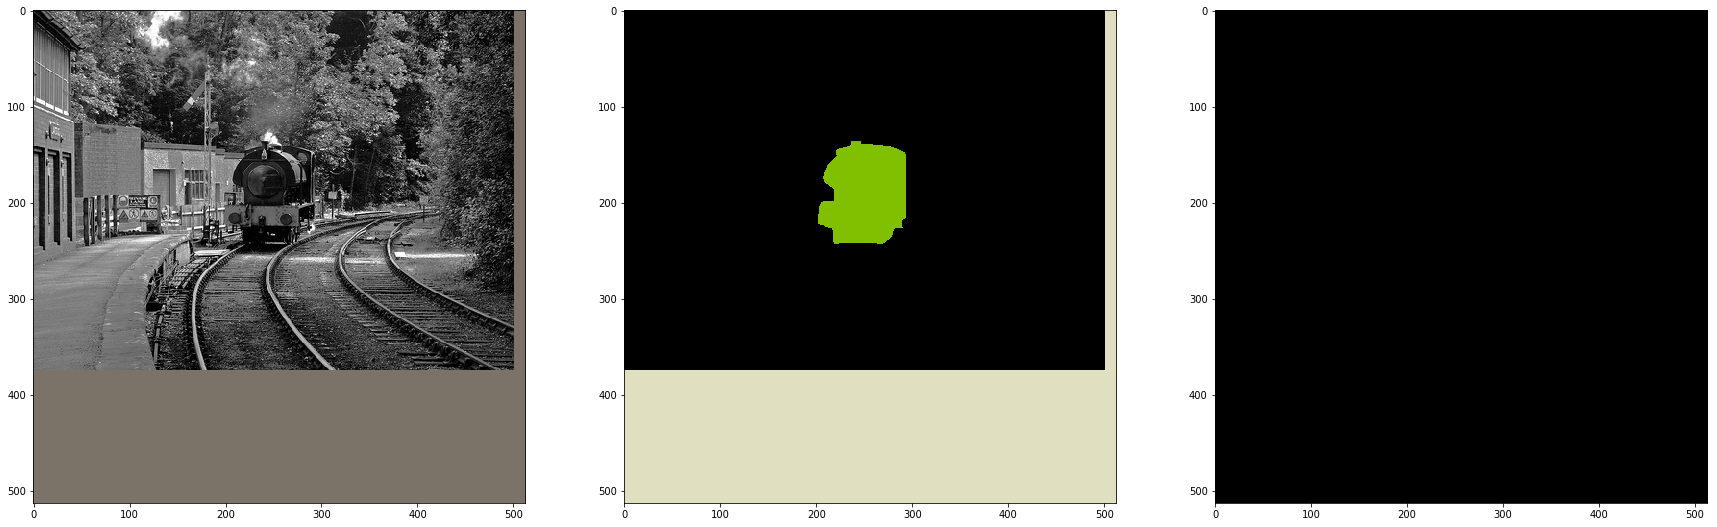

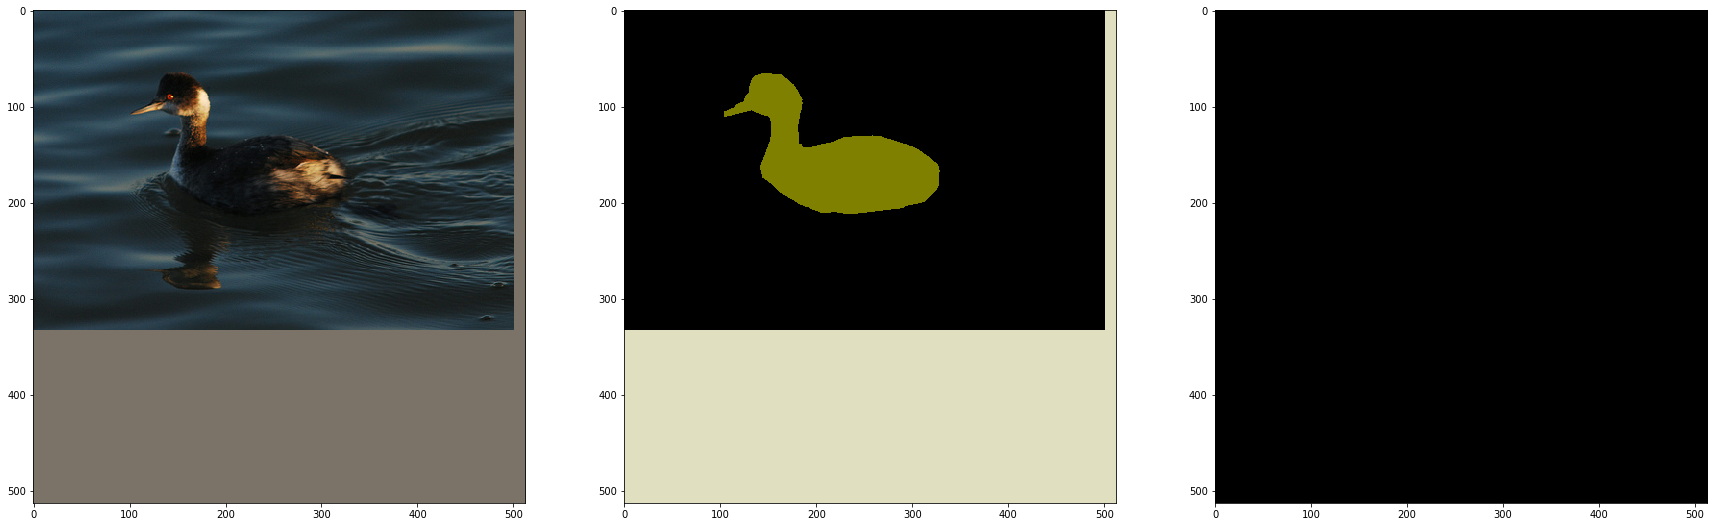

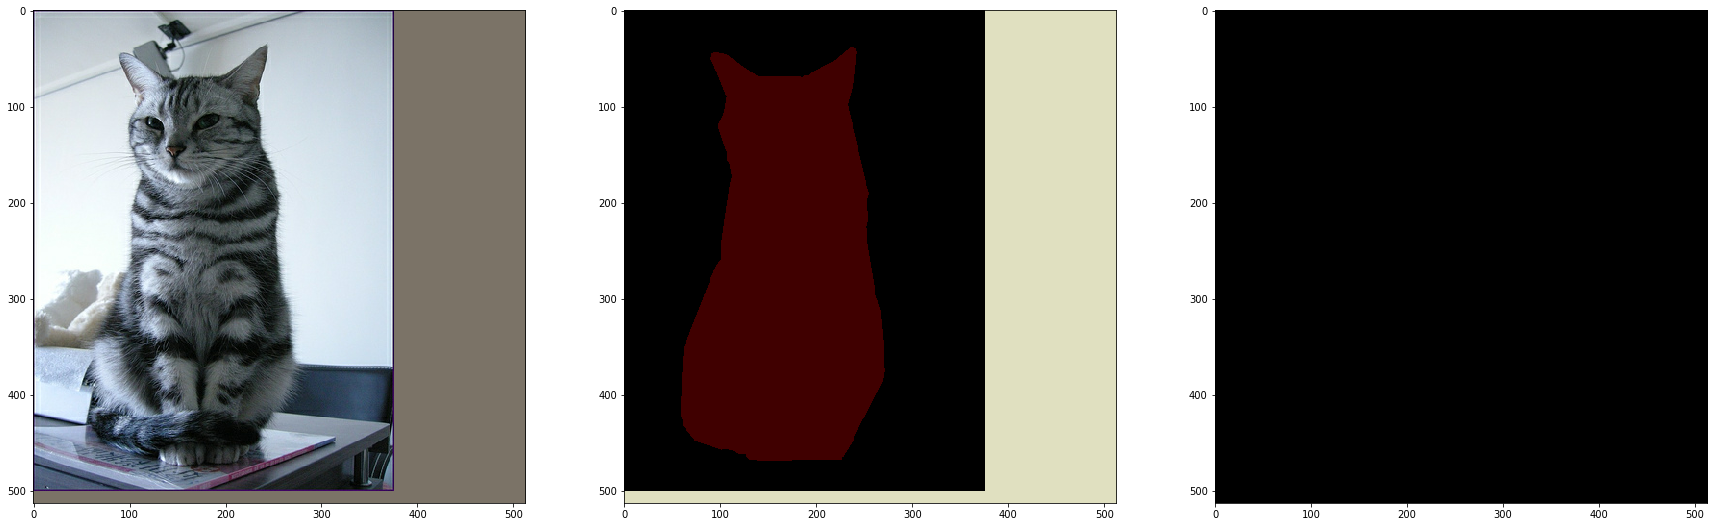

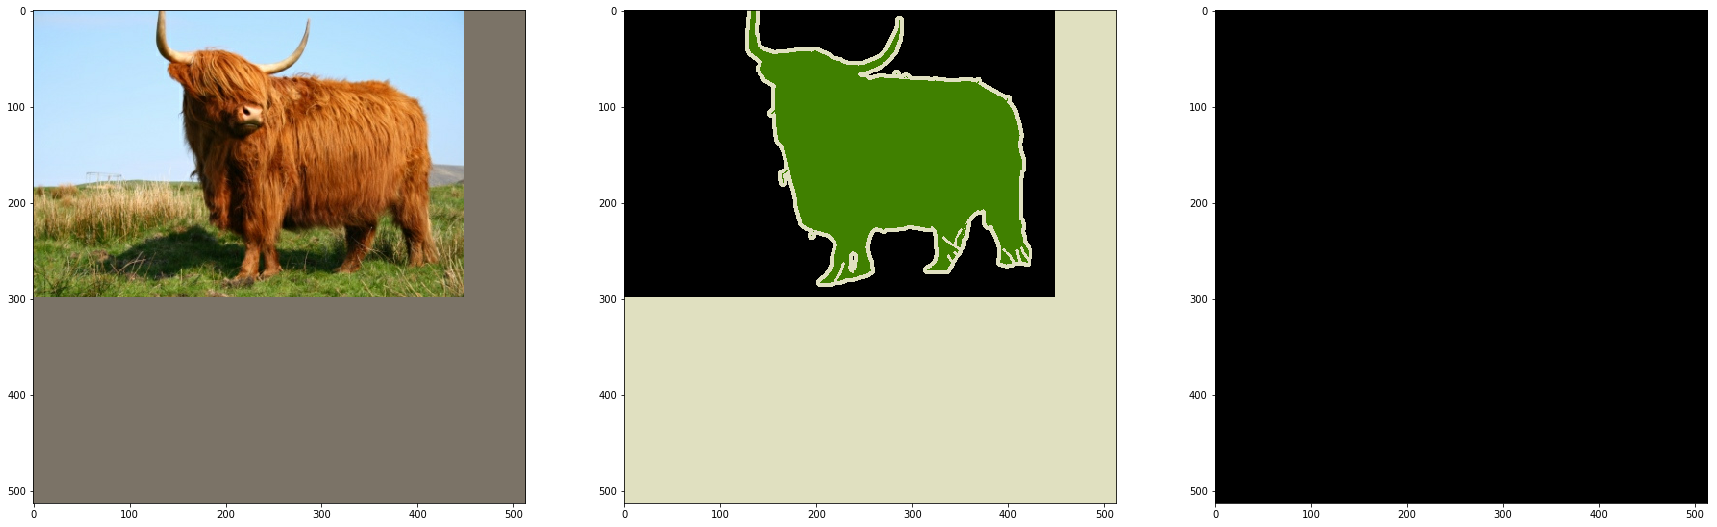

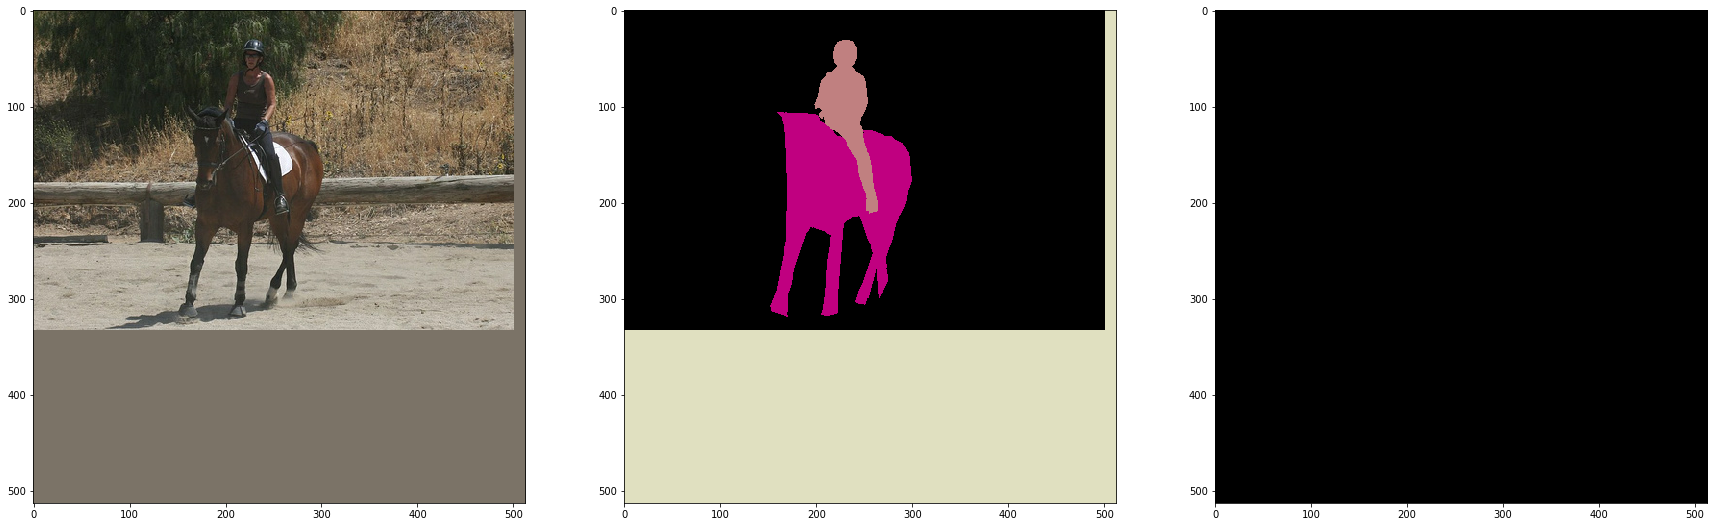

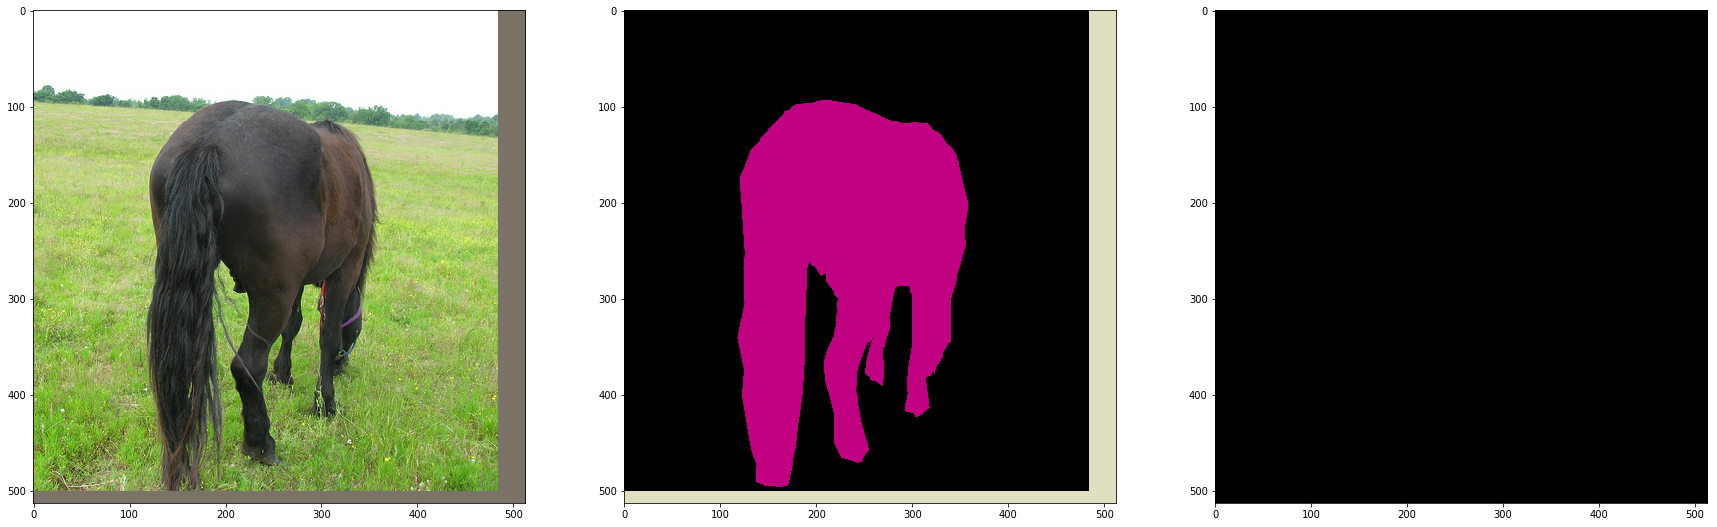

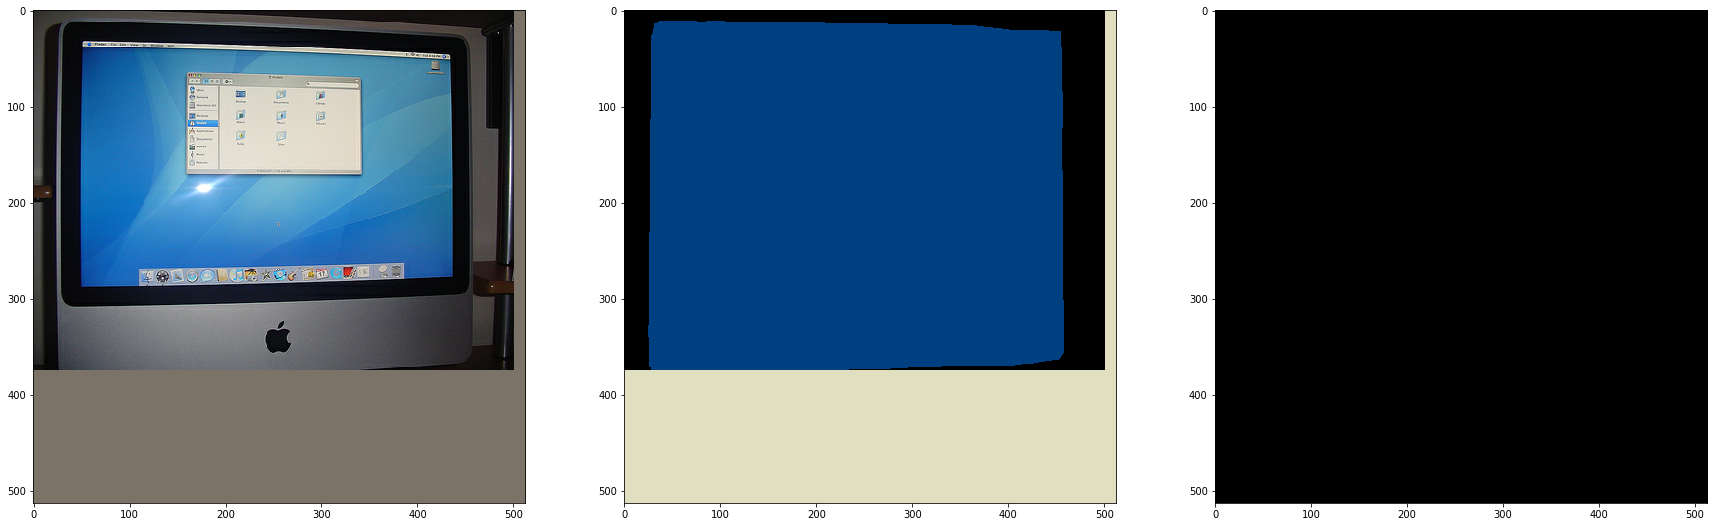

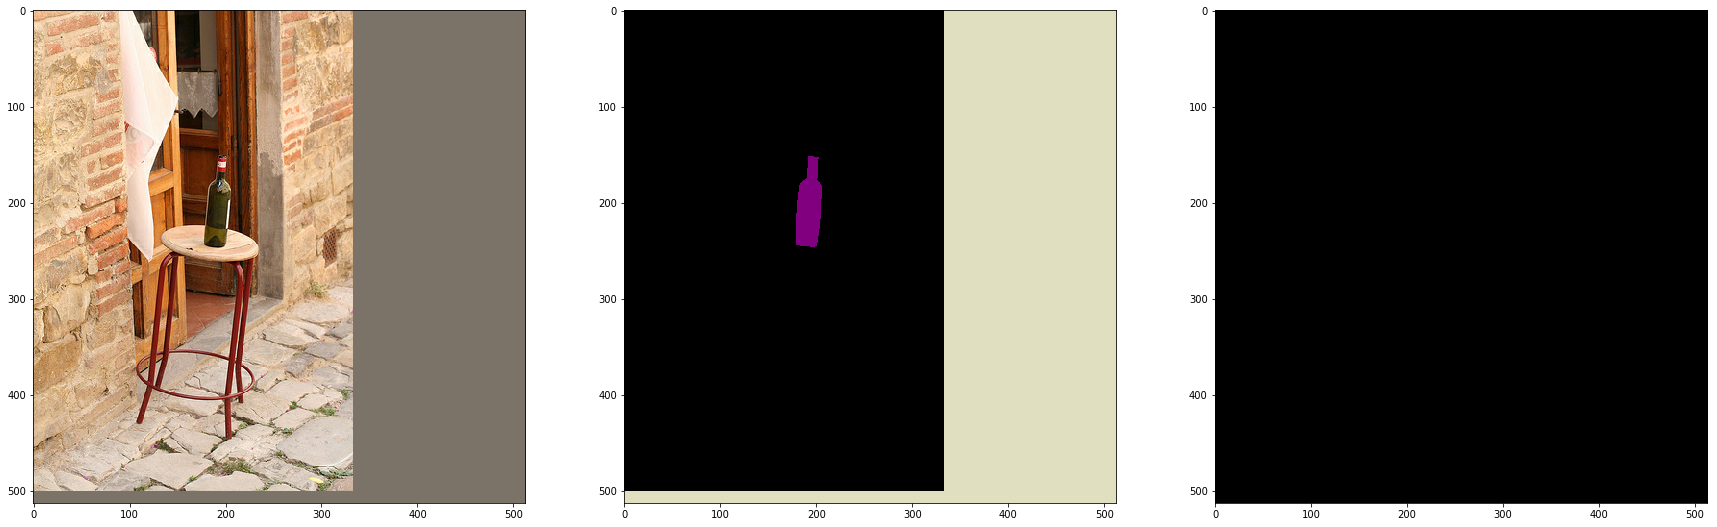

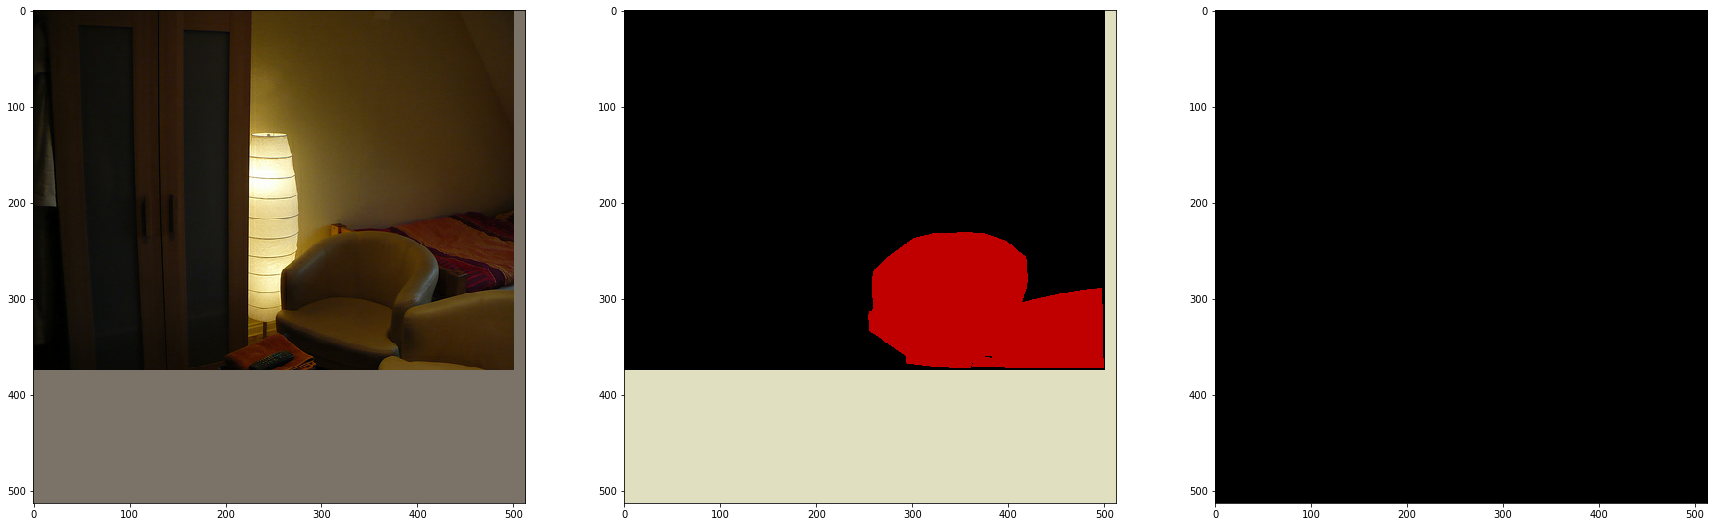

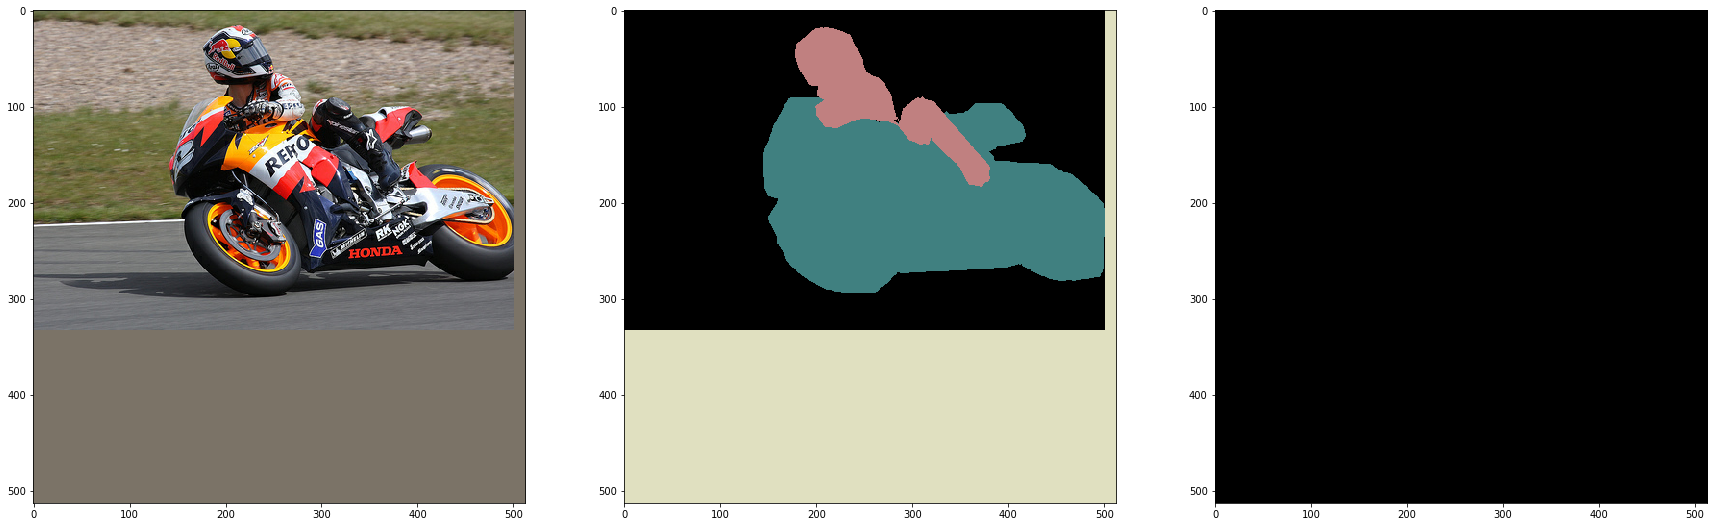

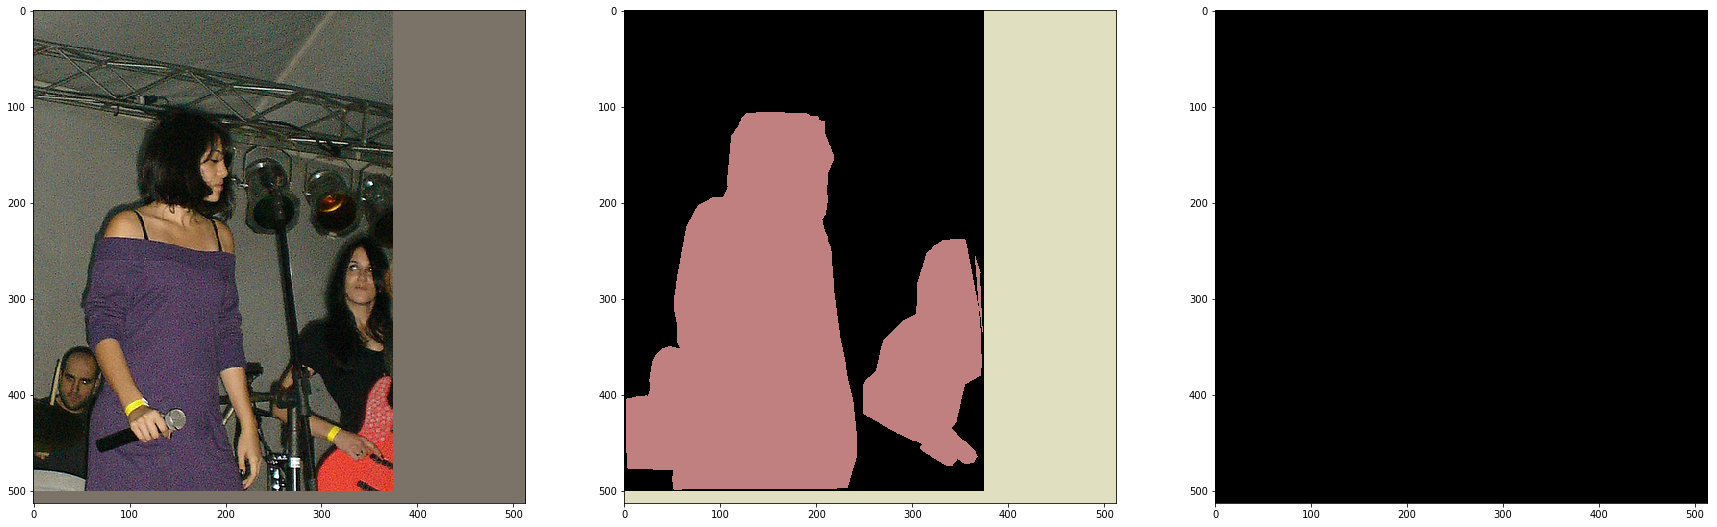

In [5]:
cnt = 0
for p in estimator_predictions:
    prepocessed_image = p['preprocessed_image'].astype(np.uint8)
#     color_label = get_dataset_colormap.label_to_color_image(p['label'][:, :, 0], dataset_name)
#     color_pred = get_dataset_colormap.label_to_color_image(p['class_ids'][:, :, 0], dataset_name)
    color_label = p['gt_color_labels']
    color_pred = p['pred_color_labels']
    fig = plt.figure(figsize=(30, 30))
    ax1 = fig.add_subplot(131)
    ax1.imshow(prepocessed_image)
    ax2 = fig.add_subplot(132)
    ax2.imshow(color_label)
    ax3 = fig.add_subplot(133)
    ax3.imshow(color_pred)
    
    cnt += 1
    if cnt > 10:
        break

In [6]:
estimator.evaluate(_val_input_fn, 100, checkpoint_path='/ssd/zhangyiyang/tensorflow-deeplab-v3-master/model/1/model.ckpt-4236')

I0718 19:26:59.824526 140174278350592 estimator.py:1145] Calling model_fn.
W0718 19:27:05.482390 140174278350592 deprecation.py:323] From /ssd/zhangyiyang/TF-Semantic-Segmentation/estimator_models/estimator_model_utils.py:45: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0718 19:27:05.487897 140174278350592 deprecation_wrapper.py:119] From /ssd/zhangyiyang/TF-Semantic-Segmentation/estimator_models/estimator_model_utils.py:52: The name tf.confusion_matrix is deprecated. Please use tf.math.confusion_matrix instead.

W0718 19:27:05.553095 140174278350592 deprecation_wrapper.py:119] From /ssd/zhangyiyang/TF-Semantic-Segmentation/estimator_models/estimator_model_utils.py:58: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

W0718 19:27:05.575558 140174278350592 deprecation_wrapper.py:119] From /ssd/zhang

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[144,5,5,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node aspp/conv_3x3_2/SpaceToBatchND (defined at /tmp/tmp_bs0_hcv.py:12) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[ConstantFoldingCtrl/mean_iou/confusion_matrix/assert_less_1/Assert/AssertGuard/Switch_0/_3544]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[144,5,5,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node aspp/conv_3x3_2/SpaceToBatchND (defined at /tmp/tmp_bs0_hcv.py:12) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node aspp/conv_3x3_2/SpaceToBatchND:
 resnet_v2_101/block4/unit_3/bottleneck_v2/add (defined at /ssd/zhangyiyang/TF-Semantic-Segmentation/builders/frontend_builder.py:34)

Input Source operations connected to node aspp/conv_3x3_2/SpaceToBatchND:
 resnet_v2_101/block4/unit_3/bottleneck_v2/add (defined at /ssd/zhangyiyang/TF-Semantic-Segmentation/builders/frontend_builder.py:34)

Original stack trace for 'aspp/conv_3x3_2/SpaceToBatchND':
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2907, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-9b548428a38f>", line 1, in <module>
    estimator.evaluate(_val_input_fn, 100, checkpoint_path='/ssd/zhangyiyang/tensorflow-deeplab-v3-master/model/1/model.ckpt-4236')
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 477, in evaluate
    name=name)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 519, in _actual_eval
    return _evaluate()
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 501, in _evaluate
    self._evaluate_build_graph(input_fn, hooks, checkpoint_path))
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1501, in _evaluate_build_graph
    self._call_model_fn_eval(input_fn, self.config))
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1537, in _call_model_fn_eval
    features, labels, ModeKeys.EVAL, config)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1146, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "/ssd/zhangyiyang/TF-Semantic-Segmentation/estimator_models/DeepLabV3.py", line 134, in deeplabv3_model_fn
    logits, init_fn = network(preprocessed_image, (mode == tf.estimator.ModeKeys.TRAIN))
  File "/ssd/zhangyiyang/TF-Semantic-Segmentation/estimator_models/DeepLabV3.py", line 111, in model
    net = atrous_spatial_pyramid_pooling(net, output_stride, batch_norm_decay, is_training)
  File "/ssd/zhangyiyang/TF-Semantic-Segmentation/estimator_models/DeepLabV3.py", line 52, in atrous_spatial_pyramid_pooling
    conv_3x3_2 = resnet_utils.conv2d_same(inputs, depth, 3, stride=1, rate=atrous_rates[1], scope='conv_3x3_2')
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/contrib/slim/python/slim/nets/resnet_utils.py", line 131, in conv2d_same
    scope=scope)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1159, in convolution2d
    conv_dims=2)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1057, in convolution
    outputs = layer.apply(inputs)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1479, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 537, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 634, in __call__
    outputs = call_fn(inputs, *args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py", line 146, in wrapper
    ), args, kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py", line 450, in converted_call
    result = converted_f(*effective_args, **kwargs)
  File "/tmp/tmp_bs0_hcv.py", line 12, in tf__call
    outputs = ag__.converted_call('_convolution_op', self, ag__.ConversionOptions(recursive=True, force_conversion=False, optional_features=(), internal_convert_user_code=True), (inputs, self.kernel), None)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py", line 356, in converted_call
    return _call_unconverted(f, args, kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py", line 255, in _call_unconverted
    return f(*args)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1079, in __call__
    return self.conv_op(inp, filter)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 635, in __call__
    return self.call(inp, filter)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 618, in _with_space_to_batch_call
    input=inp, block_shape=dilation_rate, paddings=paddings)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 9251, in space_to_batch_nd
    paddings=paddings, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()
